In [1]:
import numpy as np
import pandas as pd
import itertools as it
import pickle
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numdifftools as nd

# Read results

In [2]:
methods = ['mcmc_flat', 'mcmc_inter', 'mcmc_intra', 'msle_intra']
methods_pretty = {
    'mcmc_flat': 'MNL (MCMC)',
    'mcmc_inter': 'MXL-inter (MCMC)',
    'mcmc_intra': 'MXL-inter-intra (MCMC)',
    'msle_intra': 'MXL-inter-intra (MSL)'
}
R = 10

metrics = [
    'time',
    'probB_chosen_plugin',
    'probW_chosen_plugin',
    'brierB_plugin', 'brierW_plugin'
    ]

n_p = len(methods) * R
df_results = pd.DataFrame(index=np.arange(n_p),
                          columns=[
                              'r', 'method',
                              *metrics
                              ])

i = -1
for m, r in it.product(methods, np.arange(R)):
    i += 1
    
    #Load results
    filename = 'results_route_{}_r{}'.format(m,r)
    try:
        infile = open(filename, 'rb')
        res_tmp = pickle.load(infile)[0]
        infile.close()
        
        #Store results
        df_results['r'].iloc[i] = r
        df_results['method'].iloc[i] = m

        df_results['time'].iloc[i] = res_tmp['time']

        if m != 'msle_intra':

            df_results['probB_chosen_plugin'].iloc[i] = res_tmp['probB_chosen_plugin']
            df_results['probW_chosen_plugin'].iloc[i] = res_tmp['probW_chosen_plugin']

            df_results['brierB_plugin'].iloc[i] = res_tmp['brierB_plugin']
            df_results['brierW_plugin'].iloc[i] = res_tmp['brierW_plugin']
    except:
        print(filename, " does not exist.")

# Aggregate results

In [3]:
df_results[metrics] = df_results[metrics].astype('float')

stats = ['Mean', 'SE [\%]']
stats_func = {
    'Mean': lambda x: x.mean(),
    'SE [\%]': lambda x: x.std() / np.sqrt(x.size) if x.name == 'time' \
        else x.std() / np.sqrt(x.size) * 100
}

df_results_agg = {}
for s in stats:
    df_results_agg[s] = df_results.groupby(['method'])[metrics].agg(stats_func[s]).reset_index()

df_results_agg['Mean']

,method,time,probB_chosen_plugin,probW_chosen_plugin,brierB_plugin,brierW_plugin
0,mcmc_flat,89.034809,0.561729,0.570890,0.221393,0.214265
1,mcmc_inter,312.479245,0.561311,0.646561,0.221667,0.183322
2,mcmc_intra,2971.485434,0.561162,0.645620,0.221595,0.183380
3,msle_intra,7389.498293,NaN,NaN,NaN,NaN


# Format results
## Estimation time

In [4]:
metrics = ['time']
methods = ['mcmc_flat', 'mcmc_inter', 'mcmc_intra', 'msle_intra']

df_results_agg_mask = {k: v[v['method'].isin(methods)].copy().reset_index() \
                       for k, v in df_results_agg.items()}

cols0 = [(i,i) for i in ['method']]
cols1 = [(i,j) for i in metrics for j in stats]
cols = [*cols0, *cols1]
df_results_format = pd.DataFrame(columns=pd.MultiIndex.from_tuples(cols))
for c in cols[:4]:
    df_results_format[c] = df_results_agg_mask[stats[0]][c[0]]
for m, s in it.product(metrics, stats):
    df_results_format[(m,s)] = df_results_agg_mask[s][m]
df_results_format[('method', 'method')].replace(methods_pretty, inplace=True)
df_results_format 

method         time            
                   method         Mean     SE [\%]
0              MNL (MCMC)    89.034809    2.264767
1        MXL-inter (MCMC)   312.479245    5.960638
2  MXL-inter-intra (MCMC)  2971.485434  129.705320
3   MXL-inter-intra (MSL)  7389.498293  462.166560

In [5]:
latex = df_results_format.to_latex(escape=False, float_format="%.1f", index=False)
text_file = open("table_route_time.tex", "w")
text_file.write(latex)
text_file.close()

## Predictive accuracy

In [6]:
metrics = [
    'brierB_plugin', 'brierW_plugin',
    'probB_chosen_plugin', 'probW_chosen_plugin'
    ]
methods = ['mcmc_flat', 'mcmc_inter', 'mcmc_intra']

df_results_agg_mask = {k: v[v['method'].isin(methods)].copy().reset_index() \
                       for k, v in df_results_agg.items()}

cols0 = [(i,i) for i in ['method']]
cols1 = [(i,j) for i in metrics for j in stats]
cols = [*cols0, *cols1]
df_results_format = pd.DataFrame(columns=pd.MultiIndex.from_tuples(cols))
for c in cols[:4]:
    df_results_format[c] = df_results_agg_mask[stats[0]][c[0]]
for m, s in it.product(metrics, stats):
    df_results_format[(m,s)] = df_results_agg_mask[s][m]
df_results_format[('method', 'method')].replace(methods_pretty, inplace=True)
df_results_format

method brierB_plugin           brierW_plugin            \
                   method          Mean   SE [\%]          Mean   SE [\%]   
0              MNL (MCMC)      0.221393  0.842852      0.214265  0.394856   
1        MXL-inter (MCMC)      0.221667  0.844560      0.183322  0.417652   
2  MXL-inter-intra (MCMC)      0.221595  0.856690      0.183380  0.421048   

  probB_chosen_plugin           probW_chosen_plugin            
                 Mean   SE [\%]                Mean   SE [\%]  
0            0.561729  0.868387            0.570890  0.371029  
1            0.561311  0.882164            0.646561  0.371597  
2            0.561162  0.894288            0.645620  0.394517

In [7]:
latex = df_results_format.to_latex(escape=False, float_format="%.3f", index=False)
text_file = open("table_route_pred.tex", "w")
text_file.write(latex)
text_file.close()

## Detailed estimation results

In [8]:
methods = ['mcmc_flat', 'mcmc_inter', 'mcmc_intra', 'msle_intra']
methods_pretty = {
    'mcmc_flat': 'MNL (MCMC)',
    'mcmc_inter': 'MXL-inter (MCMC)',
    'mcmc_intra': 'MXL-inter-intra (MCMC)',
    'msle_intra': 'MXL-inter-intra (MSL)'
}
r = 0

results = {}
for m in methods:
    i += 1
    
    #Load results
    filename = 'results_route_{}_r{}'.format(m,r)
    try:
        infile = open(filename, 'rb')
        results[m] = pickle.load(infile)[1]
        infile.close()
    except:
        print(filename, " does not exist.")

In [9]:
results['msle_intra']

{'modelName': 'data_route_r0',
 'seed': 4711,
 'estimation_time': 6011.155552864075,
 'drawsType': 'mlhs',
 'nDraws_inter': 250,
 'nDraws_intra': 250,
 'drawsUc': None,
 'drawsCo': None,
 'logLik': array([-7157.11100752]),
 'est': array([-0.73204893,  0.94909359, -0.30730537,  0.29391161,  0.34964226,
         0.54635145,  0.9465566 ,  1.45959636,  0.36193963,  2.39589947,
         0.32316756,  0.14371639,  0.03738956,  1.04889272, -0.13558034,
        -0.08461333,  1.61795381, -0.08070528,  0.45041406,  2.17971699,
         0.07699653,  0.18377545,  0.17385946,  0.3292001 , -1.55976666,
         0.25774434,  0.69043605,  0.31262552,  0.34763593]),
 'iHess': array([[ 5.94401609e-03, -6.87350532e-03,  2.03998588e-03,
         -1.63203309e-03, -2.32749173e-03, -2.74718194e-03,
         -6.47294495e-03, -1.01986303e-02, -2.45113850e-03,
         -1.73635956e-02, -2.25660186e-03, -5.55779728e-04,
          8.60765821e-05, -7.14518950e-03,  1.44356742e-03,
          9.18473357e-04, -1.19776

In [10]:
methods = [v for v in methods_pretty.values()]

attributes_rnd = ['overseas destination', 'length of stay', '4-star accommodation', 'beach or pool avail.']
attributes_fix = ['price', 'meal inclusion', 'distance from hotel to attractions', 'local tours avail.', 'individual tour']

n_rnd = len(attributes_rnd)
n_fix = len(attributes_fix)

cov = ['{} vs. {}'.format(i_a,j_a) 
       for i, i_a in enumerate(attributes_rnd) 
       for j, j_a in enumerate(attributes_rnd) 
       if i >= j]
rows = [*attributes_fix, *attributes_rnd, *cov, *cov]

stats = ['Est.', 'SE']
cols0 = [(i,i) for i in ['Parameter']]
cols1 = [(i,j) for i in methods for j in stats]
cols = [*cols0, *cols1]

tril_idx = np.tril_indices(n_rnd)

sl_rnd = slice(n_fix, n_fix + n_rnd)
sl_SigmaB = slice(n_fix + n_rnd, n_fix + n_rnd + len(tril_idx[0]))
sl_SigmaW = slice(n_fix + n_rnd + len(tril_idx[0]), None)

df_est = pd.DataFrame(columns=pd.MultiIndex.from_tuples(cols))
df_est[('Parameter', 'Parameter')] = rows

df_est[(methods[0], 'Est.')].iloc[:n_fix] = results['mcmc_flat']['pdTabPostAna_paramFix']['mean'].iloc[:n_fix].values
df_est[(methods[0], 'SE')].iloc[:n_fix] = results['mcmc_flat']['pdTabPostAna_paramFix']['std. dev.'].iloc[:n_fix].values
df_est[(methods[0], 'Est.')].iloc[sl_rnd] = results['mcmc_flat']['pdTabPostAna_paramFix']['mean'].iloc[n_fix:].values
df_est[(methods[0], 'SE')].iloc[sl_rnd] = results['mcmc_flat']['pdTabPostAna_paramFix']['std. dev.'].iloc[n_fix:].values

df_est[(methods[1], 'Est.')].iloc[:n_fix] = results['mcmc_inter']['pdTabPostAna_paramFix']['mean'].values
df_est[(methods[1], 'SE')].iloc[:n_fix] = results['mcmc_inter']['pdTabPostAna_paramFix']['std. dev.'].values
df_est[(methods[1], 'Est.')].iloc[sl_rnd] = results['mcmc_inter']['pdTabPostAna_zeta']['mean'].values
df_est[(methods[1], 'SE')].iloc[sl_rnd] = results['mcmc_inter']['pdTabPostAna_zeta']['std. dev.'].values
df_est[(methods[1], 'Est.')].iloc[sl_SigmaB] = np.array(results['mcmc_inter']['pdTabPostAna_Omega']['mean'])\
    .reshape(n_rnd,n_rnd)[tril_idx]
df_est[(methods[1], 'SE')].iloc[sl_SigmaB] = np.array(results['mcmc_inter']['pdTabPostAna_Omega']['std. dev.'])\
    .reshape(n_rnd,n_rnd)[tril_idx]

df_est[(methods[2], 'Est.')].iloc[:n_fix] = results['mcmc_intra']['pdTabPostAna_paramFix']['mean'].values
df_est[(methods[2], 'SE')].iloc[:n_fix] = results['mcmc_intra']['pdTabPostAna_paramFix']['std. dev.'].values
df_est[(methods[2], 'Est.')].iloc[sl_rnd] = results['mcmc_intra']['pdTabPostAna_zeta']['mean'].values
df_est[(methods[2], 'SE')].iloc[sl_rnd] = results['mcmc_intra']['pdTabPostAna_zeta']['std. dev.'].values
df_est[(methods[2], 'Est.')].iloc[sl_SigmaB] = np.array(results['mcmc_intra']['pdTabPostAna_OmegaB']['mean'])\
    .reshape(n_rnd,n_rnd)[tril_idx]
df_est[(methods[2], 'SE')].iloc[sl_SigmaB] = np.array(results['mcmc_intra']['pdTabPostAna_OmegaB']['std. dev.'])\
    .reshape(n_rnd,n_rnd)[tril_idx]
df_est[(methods[2], 'Est.')].iloc[sl_SigmaW] = np.array(results['mcmc_intra']['pdTabPostAna_OmegaW']['mean'])\
    .reshape(n_rnd,n_rnd)[tril_idx]
df_est[(methods[2], 'SE')].iloc[sl_SigmaW] = np.array(results['mcmc_intra']['pdTabPostAna_OmegaW']['std. dev.'])\
    .reshape(n_rnd,n_rnd)[tril_idx]

df_est[(methods[3], 'Est.')].iloc[:n_fix] = results['msle_intra']['paramFix_est']
df_est[(methods[3], 'SE')].iloc[:n_fix] = results['msle_intra']['paramFix_se']
df_est[(methods[3], 'Est.')].iloc[sl_rnd] = results['msle_intra']['paramRnd2Co_mu_est']
df_est[(methods[3], 'SE')].iloc[sl_rnd] = results['msle_intra']['paramRnd2Co_mu_se']

chB_est = results['msle_intra']['paramRnd2Co_chB_est'] 
chW_est = results['msle_intra']['paramRnd2Co_chW_est']

SigmaB = chB_est @ chB_est.T
df_est[(methods[3], 'Est.')].iloc[sl_SigmaB] = SigmaB[tril_idx]
SigmaW = chW_est @ chW_est.T
df_est[(methods[3], 'Est.')].iloc[sl_SigmaW] = SigmaW[tril_idx]
    
#df_est

Use parametric bootstrap to calculate standard errors of covariance matrices for MSL

In [11]:
ch_idx = np.triu_indices(n_rnd)
ch_idx = ch_idx[1], ch_idx[0]

iHessB = np.linalg.cholesky(results['msle_intra']['iHess'][sl_SigmaB,sl_SigmaB])
iHessW = np.linalg.cholesky(results['msle_intra']['iHess'][sl_SigmaW,sl_SigmaW])

n_samples = 10000
Sigma_B_samples = np.zeros((n_samples, n_rnd, n_rnd))
Sigma_W_samples = np.zeros((n_samples, n_rnd, n_rnd))
for i in np.arange(n_samples):
    z = np.zeros((n_rnd, n_rnd))
    z[ch_idx] = iHessB @ np.random.randn(iHessB.shape[0],)
    chB = chB_est + z
    Sigma_B_samples[i,:,:] = chB @ chB.T
    
    z = np.zeros((n_rnd, n_rnd))
    z[ch_idx] = iHessW @ np.random.randn(iHessW.shape[0],)
    chW = chW_est + z
    Sigma_W_samples[i,:,:] = chW @ chW.T

In [12]:
Sigma_B_samples_mean = Sigma_B_samples.mean(axis=0, keepdims=True)
Sigma_B_samples_mean[0,:,:]

array([[ 5.82267989,  0.78971173,  0.3470528 ,  0.08649166],
       [ 0.78971173,  1.24342282, -0.09646339, -0.07905055],
       [ 0.3470528 , -0.09646339,  2.73600977, -0.11789423],
       [ 0.08649166, -0.07905055, -0.11789423,  0.23451562]])

In [13]:
Sigma_W_samples_mean = Sigma_W_samples.mean(axis=0, keepdims=True)
Sigma_W_samples_mean[0,:,:]

array([[ 4.86146381,  0.1776475 ,  0.40739837,  0.38214281],
       [ 0.1776475 ,  0.20809618, -0.46213979,  0.11886967],
       [ 0.40739837, -0.46213979,  4.73207228, -0.19592893],
       [ 0.38214281,  0.11886967, -0.19592893,  1.19836707]])

In [14]:
SigmaB_se = np.sqrt(np.sum((Sigma_B_samples - Sigma_B_samples_mean)**2, axis=0) 
                    / (n_samples - 1))
SigmaW_se = np.sqrt(np.sum((Sigma_W_samples - Sigma_W_samples_mean)**2, axis=0) 
                    / (n_samples - 1))

In [15]:
df_est[(methods[3], 'SE')].iloc[sl_SigmaB] = SigmaB_se[tril_idx]
df_est[(methods[3], 'SE')].iloc[sl_SigmaW] = SigmaW_se[tril_idx]

df_est

Parameter MNL (MCMC)             \
                                        Parameter       Est.         SE   
0                                           price   0.175478  0.0192723   
1                                  meal inclusion   0.369952   0.019359   
2              distance from hotel to attractions   0.666478  0.0178396   
3                              local tours avail.    0.18904   0.012251   
4                                 individual tour  -0.314863   0.024014   
5                            overseas destination   0.411683  0.0211127   
6                                  length of stay  -0.145255  0.0202705   
7                            4-star accommodation   0.143713  0.0258323   
8                            beach or pool avail.   0.177369  0.0257088   
9   overseas destination vs. overseas destination        NaN        NaN   
10        length of stay vs. overseas destination        NaN        NaN   
11              length of stay vs. length of stay        NaN        NaN   
12  4-star accommodation vs. overseas destination        NaN        NaN   
13        4-star accommodation vs. length of stay        NaN        NaN   
14  4-star accommodation vs. 4-star accommodation        NaN        NaN   
15  beach or pool avail. vs. overseas destination        NaN        NaN   
16        beach or pool avail. vs. length of stay        NaN        NaN   
17  beach or pool avail. vs. 4-star accommodation        NaN        NaN   
18  beach or pool avail. vs. beach or pool avail.        NaN        NaN   
19  overseas destination vs. overseas destination        NaN        NaN   
20        length of stay vs. overseas destination        NaN        NaN   
21              length of stay vs. length of stay        NaN        NaN   
22  4-star accommodation vs. overseas destination        NaN        NaN   
23        4-star accommodation vs. length of stay        NaN        NaN   
24  4-star accommodation vs. 4-star accommodation        NaN        NaN   
25  beach or pool avail. vs. overseas destination        NaN        NaN   
26        beach or pool avail. vs. length of stay        NaN        NaN   
27  beach or pool avail. vs. 4-star accommodation        NaN        NaN   
28  beach or pool avail. vs. beach or pool avail.        NaN        NaN   

   MXL-inter (MCMC)            MXL-inter-intra (MCMC)             \
               Est.         SE                   Est.         SE   
0         -0.445197  0.0347473              -0.733845  0.0902661   
1          0.560374  0.0289039               0.971539   0.135961   
2         -0.183517   0.027747              -0.310954  0.0593587   
3          0.187296  0.0309221               0.297697  0.0583592   
4          0.215172  0.0296081               0.349506  0.0598314   
5          0.298265  0.0659718               0.544827   0.139172   
6           0.56855   0.045009                1.00505   0.157098   
7          0.912782  0.0498218                1.53431   0.222888   
8          0.233537   0.023461               0.363013  0.0580892   
9            1.8393   0.183049                6.14922    1.55821   
10         0.225105  0.0843806               0.736564   0.307906   
11         0.430498  0.0727195                 1.4082   0.396911   
12        0.0843235  0.0873824               0.246776    0.29987   
13         0.016525  0.0583875               0.106666   0.188778   
14         0.990318  0.0994339                2.92268   0.814944   
15        0.0290543  0.0388363              0.0966701   0.128942   
16      -0.00531065  0.0238715              -0.035269  0.0744337   
17       -0.0215827  0.0296691              -0.093109    0.10172   
18        0.0956767  0.0197764               0.259957  0.0856488   
19              NaN        NaN                5.23986    1.74329   
20              NaN        NaN               0.176336    0.29792   
21              NaN        NaN               0.190961    0.19569   
22              NaN        NaN               0.277848   0.542878   
23            

In [16]:
def format_string(x):
    if isinstance(x, float):
        if np.isnan(x):
            return ' '
        else:
            return '{:.3f}'.format(x)
    else:
        return '\quad ' + x.capitalize()
df_est_format = df_est.applymap(format_string)

In [17]:
pd.options.display.max_colwidth = 1000
latex = df_est_format.to_latex(escape=False, index=False)
text_file = open("table_route_est.tex", "w")
text_file.write(latex)
text_file.close()

# Test results
Perform t-tests to check whether within-individuals predictive accuracy is statistically significantly different across two methods.

In [18]:
def t_test(m1, m2, v1, v2):
    cat1 = df_results[df_results['method'] == m1]
    cat2 = df_results[df_results['method'] == m2]
    print(ttest_ind(cat1[v1], cat2[v2]))

In [19]:
t_test('mcmc_inter', 'mcmc_intra', 'brierW_plugin', 'brierW_plugin')

Ttest_indResult(statistic=-0.009925949036753383, pvalue=0.9921895546387496)


In [20]:
t_test('mcmc_inter', 'mcmc_flat', 'brierW_plugin', 'brierW_plugin')

Ttest_indResult(statistic=-5.383734473827646, pvalue=4.077268019790802e-05)


In [21]:
t_test('mcmc_intra', 'mcmc_flat', 'brierW_plugin', 'brierW_plugin')

Ttest_indResult(statistic=-5.3504735561217585, pvalue=4.3759326761798553e-05)


# Visually compare predictive accuracy

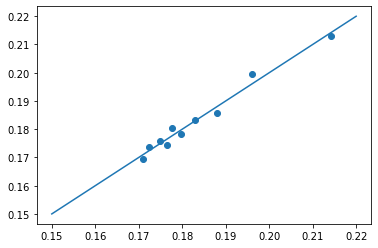

In [22]:
fig, ax = plt.subplots()
ax.scatter(df_results[df_results['method'] == 'mcmc_inter']['brierW_plugin'],
           df_results[df_results['method'] == 'mcmc_intra']['brierW_plugin'])
plt.plot([0.15, 0.22], [0.15, 0.22])
plt.show()